# Случайный лес(классификатор)

## Импорт библиотек

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import missingno as msno

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

## EDA

In [42]:
df = pd.read_csv('../frameworks-labs_nm/spaceship-titanic/train.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
df.shape

(8693, 14)

In [6]:
df['Transported'].value_counts()

Transported
True     4378
False    4315
Name: count, dtype: int64

Видим что классы сбалансированы, значит можем использовать accuracy.

Заменим true и false на 1 и 0 соответственно

In [43]:
df[['Transported', 'CryoSleep', 'VIP']] = df[['Transported', 'CryoSleep', 'VIP']].apply(lambda col: col.map(lambda x: 1 if x is True else (0 if x is False else x)))

In [18]:
df['Transported'].value_counts()

Transported
1    4378
0    4315
Name: count, dtype: int64

Посмотрим на категориальные и числовые признаки

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   float64
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   float64
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   int64  
dtypes: float64(8), int64(1), object(5)
memory usage: 950.9+ KB


In [20]:
df.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
count,8476.000000,8514.000000,8490.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,0.358306,28.827930,0.023439,224.687617,458.077203,173.729169,311.138778,304.854791,0.503624
std,0.479531,14.489021,0.151303,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.500016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,38.000000,0.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1.000000
max,1.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000


In [21]:
df.describe(include='object')

,PassengerId,HomePlanet,Cabin,Destination,Name
count,8693,8492,8494,8511,8493
unique,8693,3,6560,3,8473
top,0001_01,Earth,G/734/S,TRAPPIST-1e,Gollux Reedall
freq,1,4602,8,5915,2


Теперь займемся обработкой пропусков

In [22]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

<Axes: >

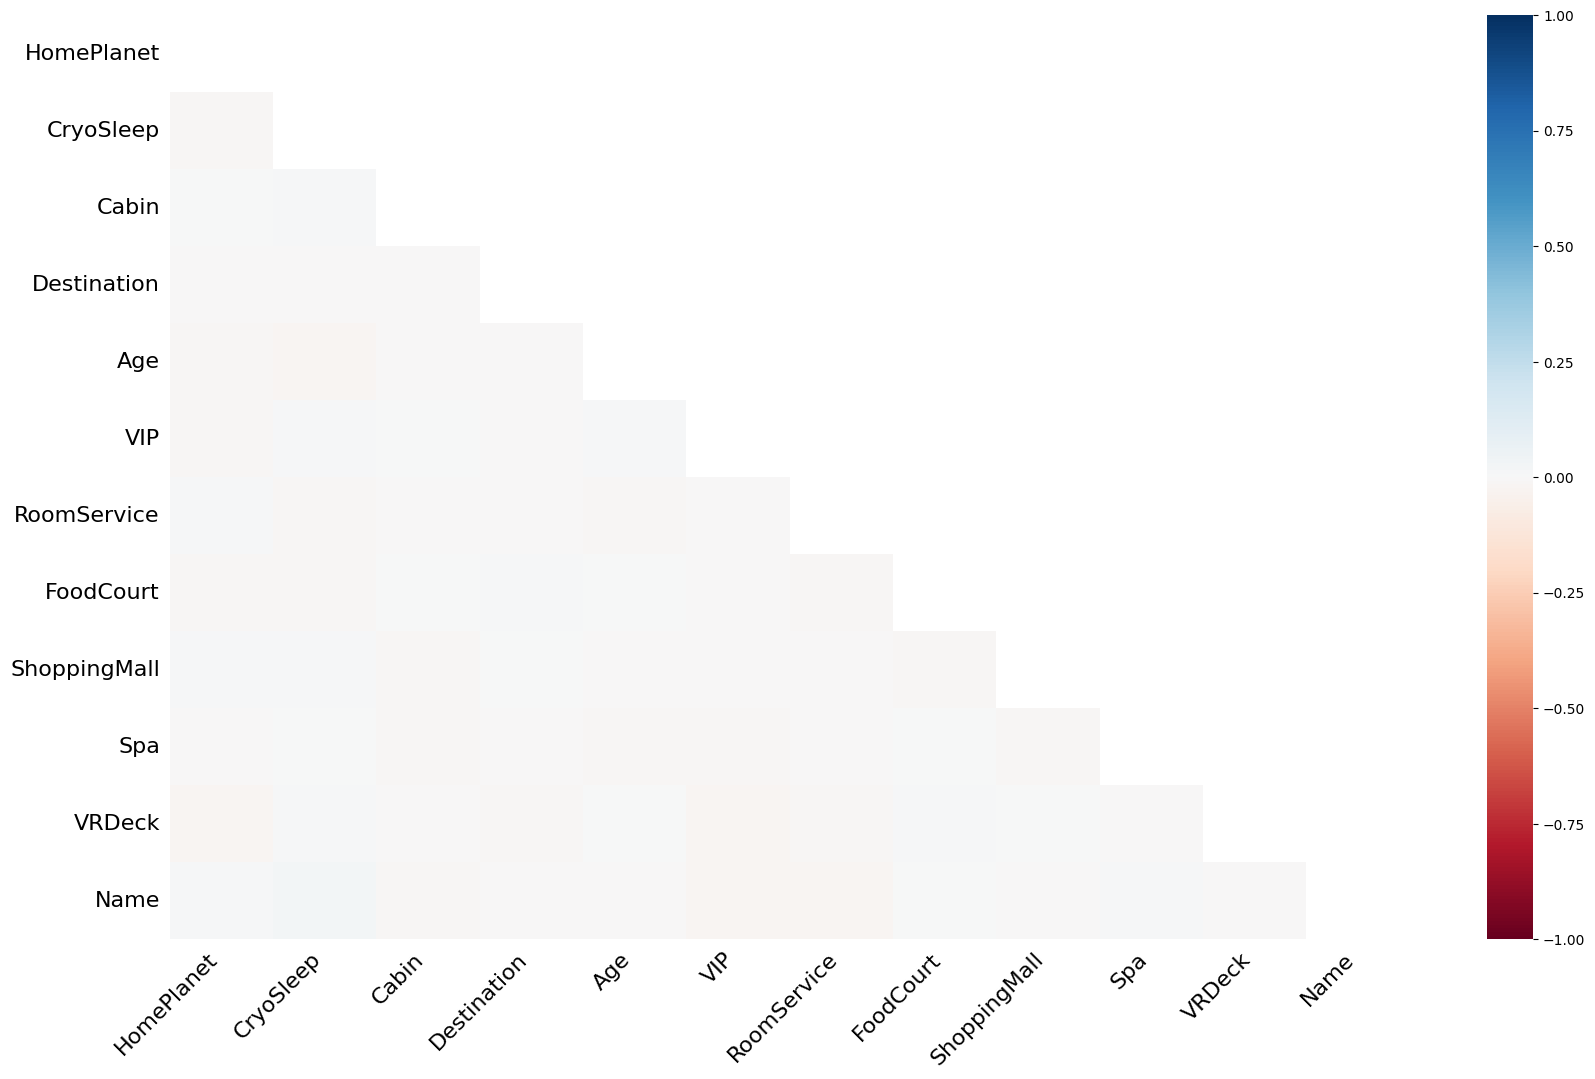

In [23]:
msno.heatmap(df)


Видим, что пропуски никак не коррелируют между собой, значит можем использовать стандартные методы их заполнения. Теперь посмотрим на них детальнее

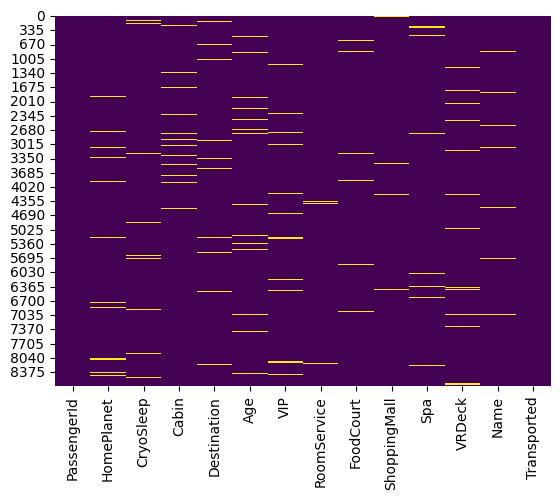

In [24]:

sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()

Итак по тепловой карте можем сделать предположение:
1) Пассажиры, которые находятся в криосне не совершали покупок в различных сервисах и как следствие пропуски у пассажиров, где CryoSleep == True мы должны заполнить 0.


In [44]:
df[(df['CryoSleep'] == 1) & (df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]).isna().any(axis=1)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
7,0006_02,Earth,1.0,G/0/S,TRAPPIST-1e,28.0,0.0,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,1
10,0008_02,Europa,1.0,B/1/P,TRAPPIST-1e,34.0,0.0,0.0,0.0,NaN,0.0,0.0,Altardr Flatic,1
23,0020_03,Earth,1.0,E/0/S,55 Cancri e,29.0,0.0,0.0,0.0,NaN,0.0,0.0,Mollen Mcfaddennon,0
25,0020_05,Earth,1.0,E/0/S,PSO J318.5-22,1.0,0.0,NaN,0.0,0.0,0.0,0.0,Mael Brantuarez,0
28,0024_01,Europa,1.0,C/2/S,TRAPPIST-1e,62.0,0.0,0.0,0.0,NaN,0.0,0.0,Penton Fullided,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8600,9179_03,Earth,1.0,G/1494/P,PSO J318.5-22,18.0,0.0,0.0,0.0,NaN,0.0,0.0,Darley Tranciams,0
8607,9186_01,Mars,1.0,F/1878/P,TRAPPIST-1e,2.0,0.0,0.0,0.0,NaN,0.0,0.0,Mass Homin,1
8642,9221_01,Earth,1.0,G/1497/P,TRAPPIST-1e,21.0,0.0,0.0,0.0,0.0,0.0,NaN,Elicey Beachez,0
8643,9222_01,Mars,1.0,F/1784/S,TRAPPIST-1e,50.0,0.0,0.0,0.0,0.0,NaN,0.0,Carves Chate,1


Гипотеза верна как в одну так и вдругую сторону!


In [45]:
mask = (df['CryoSleep'] == 1) & (df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].isna().any(axis=1))

df.loc[mask, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = df.loc[mask, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)

In [46]:
no_spending = (df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1) == 0)

df.loc[df["CryoSleep"].isnull(), "CryoSleep"] = no_spending[df["CryoSleep"].isnull()].astype(int)

Посмотрим распределение возраста и посмотрим на vip относительно него

<Axes: xlabel='Age', ylabel='Count'>

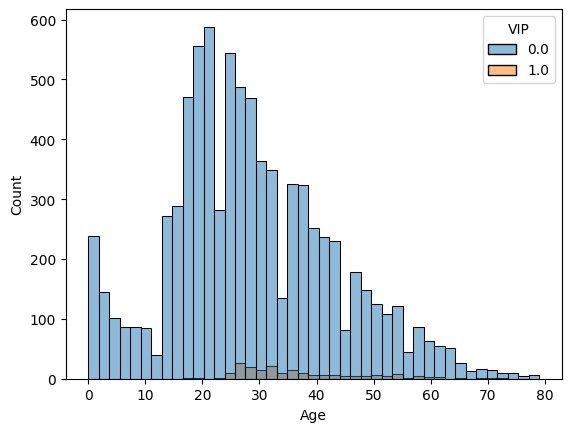

In [28]:
sns.histplot(data=df, x='Age', hue='VIP')

In [29]:
df['VIP'].value_counts()

VIP
0.0    8291
1.0     199
Name: count, dtype: int64

Мы видим, что распределение не является нормальным, а имеет правую скошенность, значит среднее значение > медианы => медианна предпочтительней, также посмотрим на vip: мы видим что доля не vip очень высокая => заполнять пропуски с помощью моделей бессмысленно при таком дисбалансе классов, самое логичное решение заполнить простой модой, а age заполним медианной по группе vip.

In [47]:
df['VIP'] = df['VIP'].fillna(0.0)

In [48]:
df['Age'] = df.groupby('VIP')['Age'].transform(lambda x: x.fillna(x.median()))

Проверим предположение, что  пассажиры из одиннаковых групп летят c/на одной и той же планеты.

In [49]:
df['№_of_group'], df['№_in_group'] = df['PassengerId'].apply(lambda x : x.split('_')[0]), df['PassengerId'].apply(lambda x : x.split('_')[1])

In [50]:
dest = df.groupby('№_of_group')['HomePlanet'].nunique()

print(f"Процент групп, где все люди с одной планеты: {(dest == 1).sum() / dest.shape[0] * 100}%")

Процент групп, где все люди с одной планеты: 98.23065787357245%


In [51]:
df['HomePlanet'] = df.groupby('№_of_group')['HomePlanet'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else df['HomePlanet'].mode()[0]))

df['Destination'] = df.groupby('№_of_group')['Destination'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else df['Destination'].mode()[0]))

Сделаем вывод, что почти все группы формируются на одной планете, но не все группы летят в одно место, часть людей могла менять маршрут.

In [35]:
df.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           199
Destination       0
Age               0
VIP               0
RoomService     113
FoodCourt       113
ShoppingMall    112
Spa             118
VRDeck          126
Name            200
Transported       0
№_of_group        0
№_in_group        0
dtype: int64

Далее чтобы заполнить оставшиеся пропуски в колонках с тратами, посмотрим на распределение трат vip/no vip пассажиров

In [52]:
vip_spending = df.groupby("VIP")[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].mean()
print(vip_spending)


     RoomService    FoodCourt  ShoppingMall         Spa       VRDeck
VIP                                                                 
0.0   217.076446   423.162175    170.028973  298.189209   280.969179
1.0   473.615385  1802.056701    247.726804  756.868687  1228.556122


In [53]:
vip_spending = df.groupby("VIP")[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].max()
print(vip_spending)


     RoomService  FoodCourt  ShoppingMall      Spa   VRDeck
VIP                                                        
0.0      14327.0    27071.0       23492.0  22408.0  24133.0
1.0       8243.0    29813.0        3700.0  13902.0  12424.0


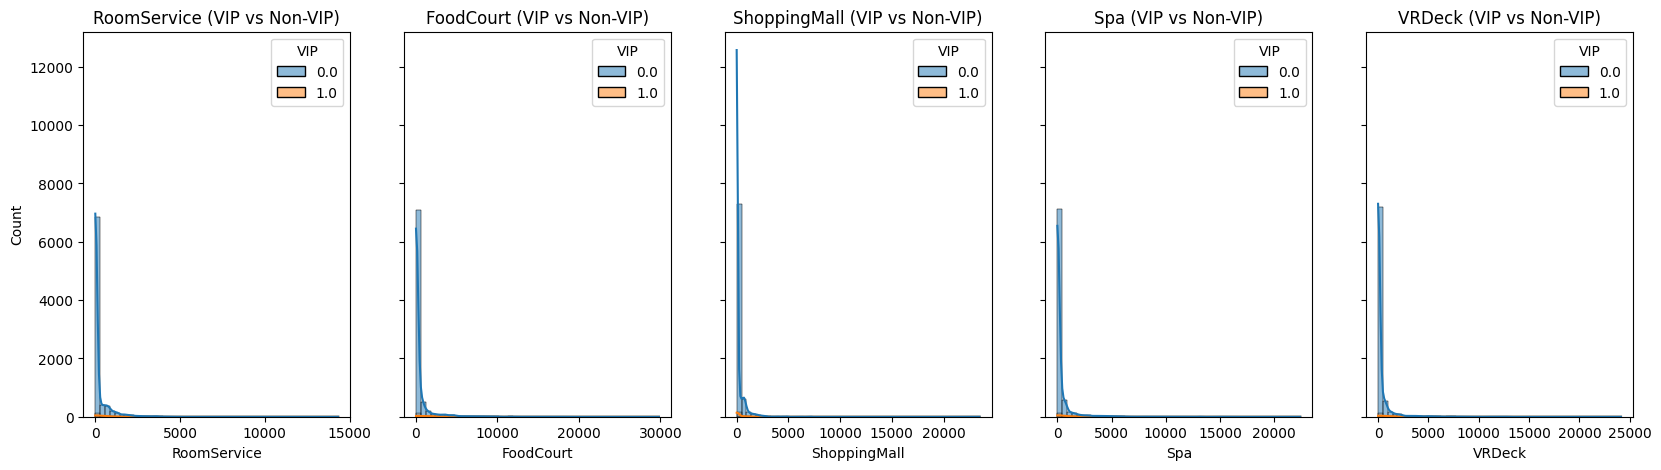

In [13]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

for i, col in enumerate(cols):
    sns.histplot(data=df, x=col, hue="VIP", bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"{col} (VIP vs Non-VIP)")

plt.show()


Итак мы видим, что траты как средние так и максимальные у vip персон логичные, а вот у no-vip есть выбросы, избавимся от них

In [54]:
vip_spending = df.groupby("VIP")[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].max().loc[1]

mask = (df["VIP"] == 0) & (
    (df["RoomService"] > vip_spending["RoomService"]) |
    (df["FoodCourt"] > vip_spending["FoodCourt"]) |
    (df["ShoppingMall"] > vip_spending["ShoppingMall"]) |
    (df["Spa"] > vip_spending["Spa"]) |
    (df["VRDeck"] > vip_spending["VRDeck"])
)

df = df[~mask]


In [40]:
df.shape

(8637, 16)

In [41]:
vip_spending = df.groupby("VIP")[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].max()
print(vip_spending)

     RoomService  FoodCourt  ShoppingMall      Spa   VRDeck
VIP                                                        
0.0       8209.0    27071.0        3700.0  13208.0  12392.0
1.0       8243.0    29813.0        3700.0  13902.0  12424.0


In [42]:
vip_spending = df.groupby("VIP")[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].mean()
print(vip_spending)

     RoomService    FoodCourt  ShoppingMall         Spa       VRDeck
VIP                                                                 
0.0   213.197335   412.607370    144.482655  277.200913   260.423572
1.0   473.615385  1802.056701    247.726804  756.868687  1228.556122


In [55]:
columns = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

for col in columns:
    mean_vip = df.loc[df["VIP"] == 1, col].mean()
    median_non_vip = df.loc[df["VIP"] == 0, col].median()

    df.loc[(df["VIP"] == 1) & (df[col].isna()), col] = mean_vip
    df.loc[(df["VIP"] == 0) & (df[col].isna()), col] = median_non_vip

In [56]:
df.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           198
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            198
Transported       0
№_of_group        0
№_in_group        0
dtype: int64

Теперь разберемся с Cabin

In [57]:
df['Deck'] = df['Cabin'].str.split('/').str[0]
df['Num'] = df['Cabin'].str.split('/').str[1]
df['Side'] = df['Cabin'].str.split('/').str[2]

deck_consistency = df.groupby('№_of_group')['Deck'].nunique(dropna=True)
side_consistency = df.groupby('№_of_group')['Side'].nunique(dropna=True)

print(f"Процент групп с одинаковым Deck: {(deck_consistency == 1).sum() / deck_consistency.shape[0] * 100}%")
print(f"Процент групп с одинаковым Side: {(side_consistency == 1).sum() / side_consistency.shape[0] * 100}%")

Процент групп с одинаковым Deck: 91.58455822968826%
Процент групп с одинаковым Side: 98.38475205944113%


Отлично! Можем сделать вывод, что  надо заполнить пропуски в Deck и Side на основе группы.

In [58]:
df['Deck'] = df.groupby('№_of_group')['Deck'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else df['Deck'].mode()[0])
)
df['Side'] = df.groupby('№_of_group')['Side'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else df['Side'].mode()[0])
)

deck_side_nums = df.groupby(['Deck', 'Side'])['Num'].apply(lambda x: x.dropna().unique()).to_dict()
df['Num'] = df.apply(
    lambda row: row['Num'] if pd.notna(row['Num']) else np.random.choice(
        deck_side_nums.get((row['Deck'], row['Side']), ['0'])
    ),
    axis=1
)

df['Num'] = pd.to_numeric(df['Num'], errors='coerce')

Отлично, пропуски мы заполнили и от выбросов избавились, детальнее анализируем признаки.

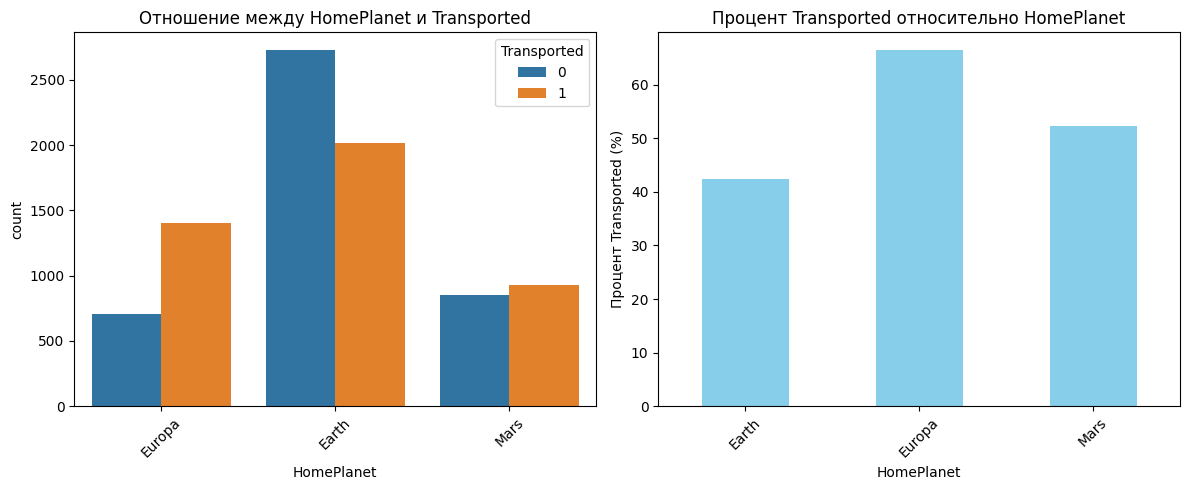

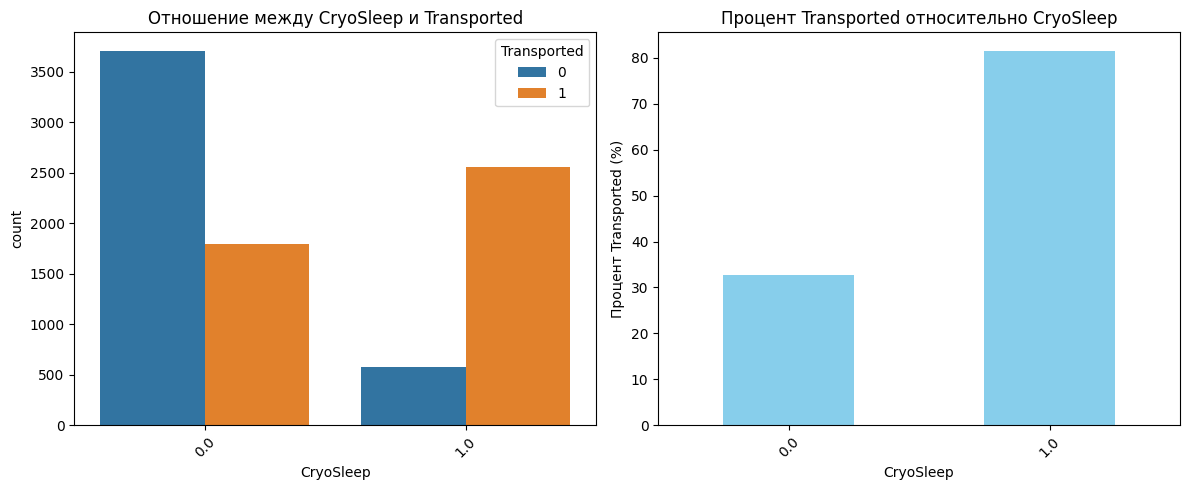

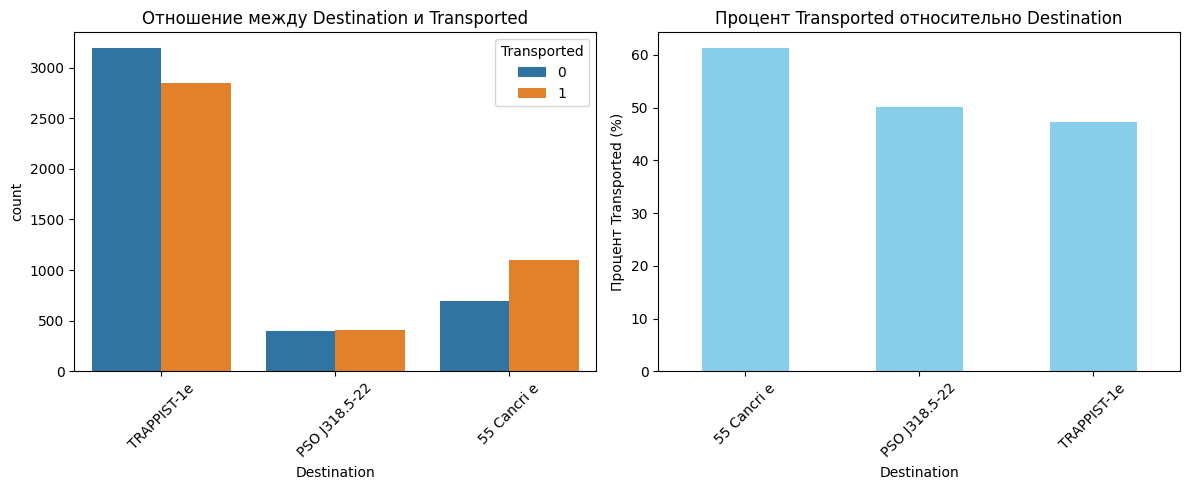

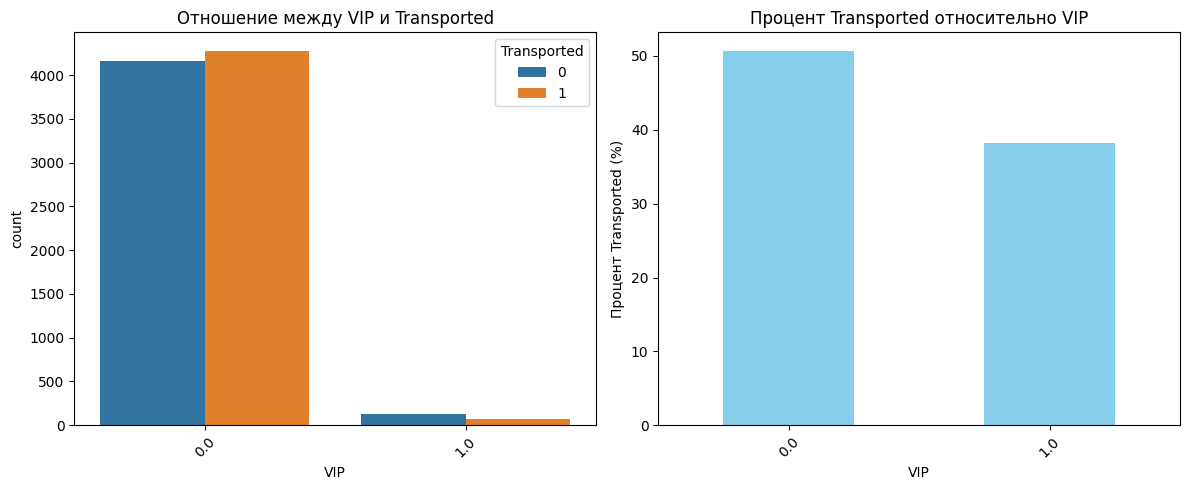

In [59]:
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

for feature in categorical_features:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x=feature, hue='Transported', data=df)
    plt.title(f'Отношение между {feature} и Transported')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    transport_rate = df.groupby(feature)['Transported'].mean() * 100
    transport_rate.plot(kind='bar', color='skyblue')
    plt.title(f'Процент Transported относительно {feature}')
    plt.ylabel('Процент Transported (%)')
    plt.xticks(rotation=45)

    plt.tight_layout()

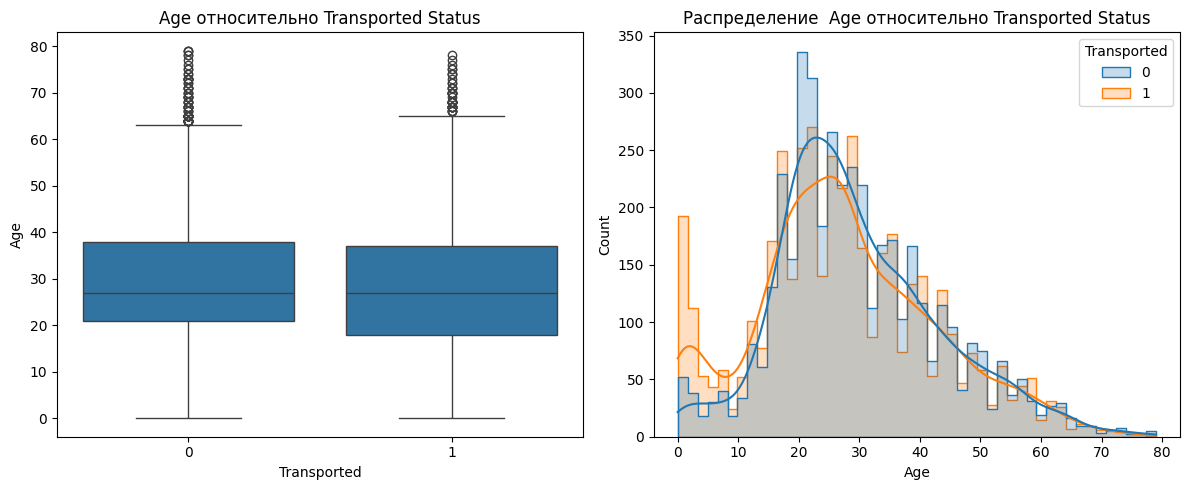

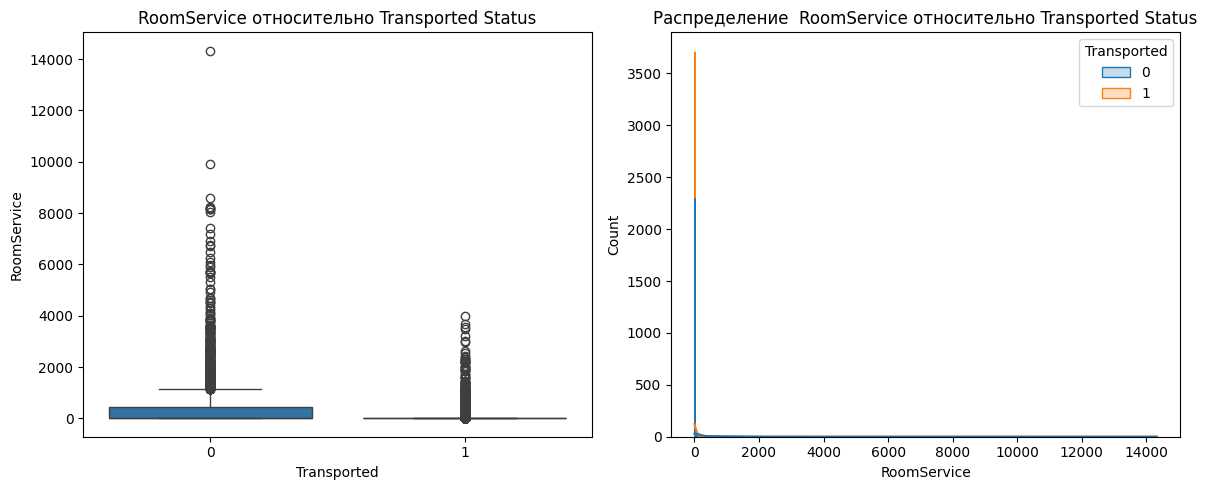

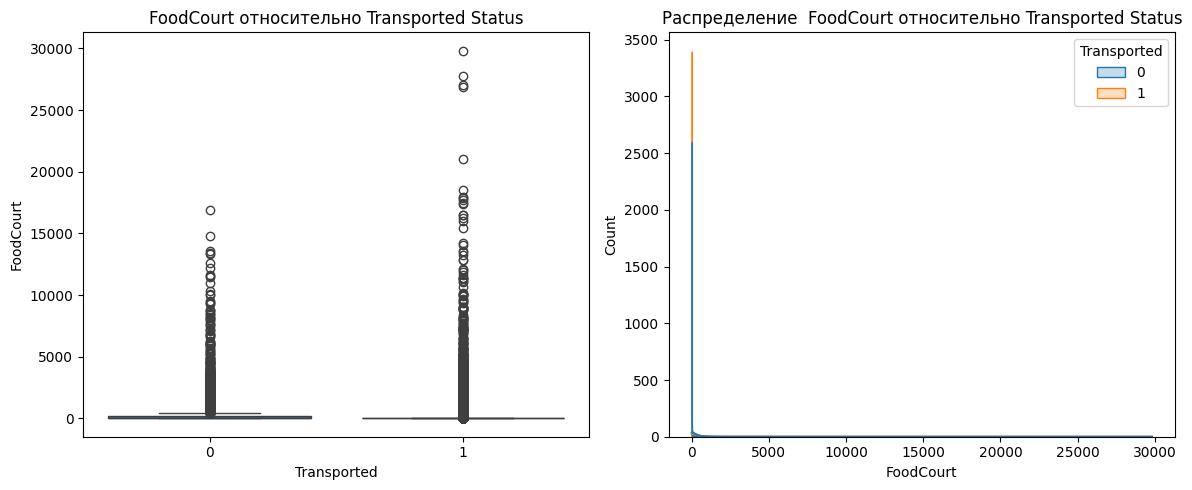

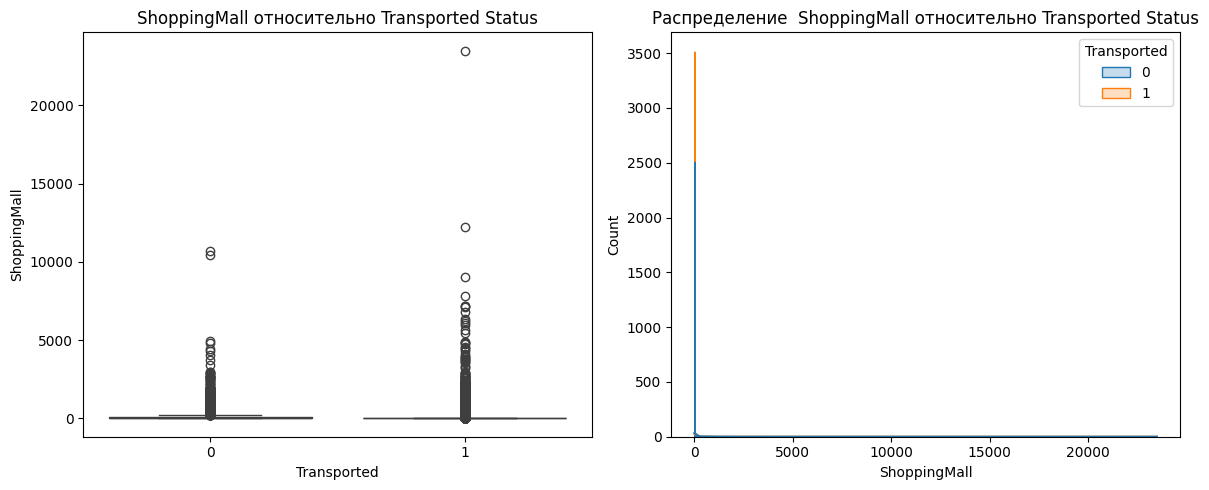

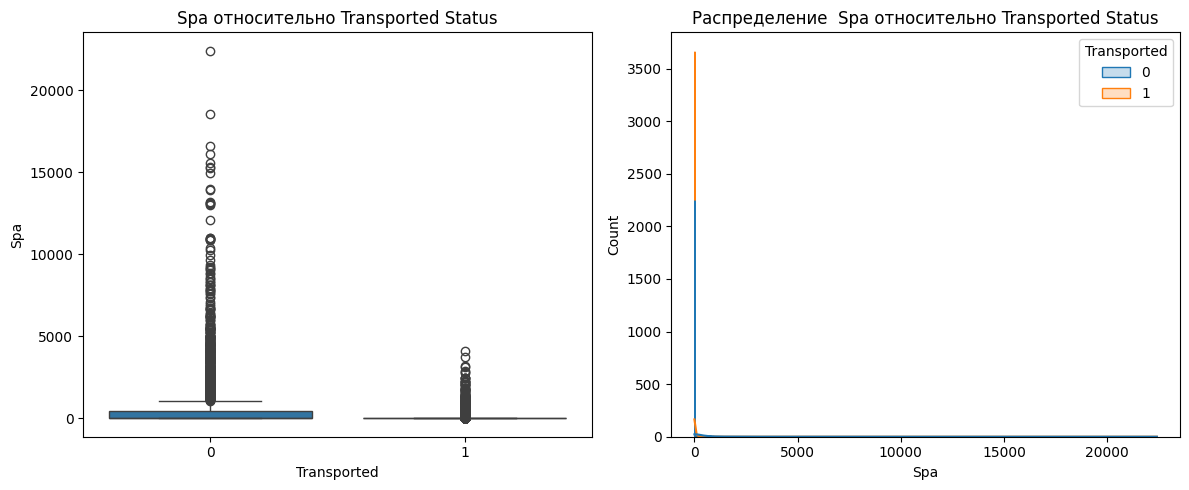

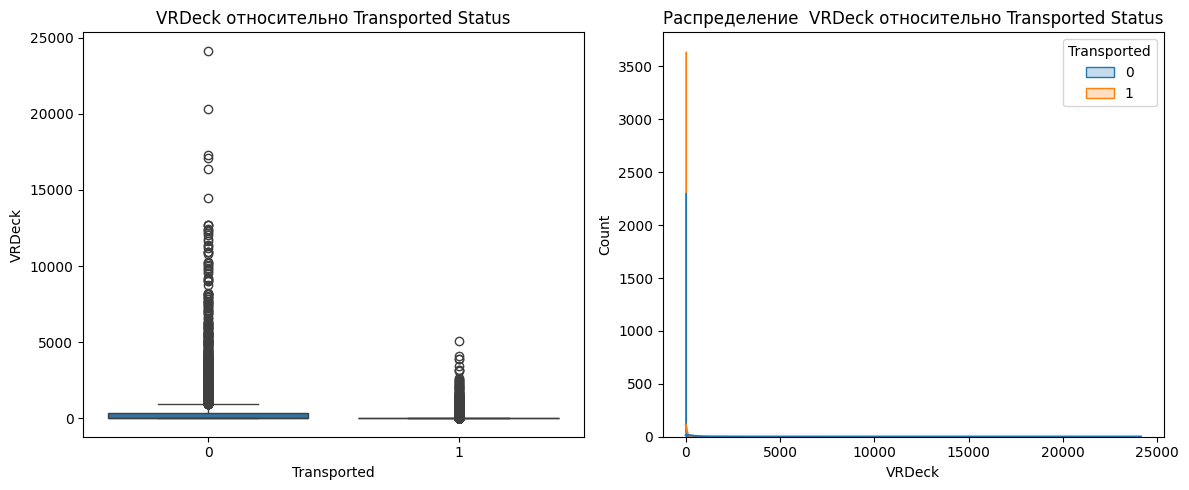

In [15]:

numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for feature in numerical_features:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(x='Transported', y=feature, data=df)
    plt.title(f'{feature} относительно Transported Status')

    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x=feature, hue='Transported', element='step', kde=True, common_norm=False)
    plt.title(f'Распределение  {feature} относительно Transported Status')

    plt.tight_layout()

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'B'),
  Text(1, 0, 'F'),
  Text(2, 0, 'A'),
  Text(3, 0, 'G'),
  Text(4, 0, 'E'),
  Text(5, 0, 'D'),
  Text(6, 0, 'C'),
  Text(7, 0, 'T')])

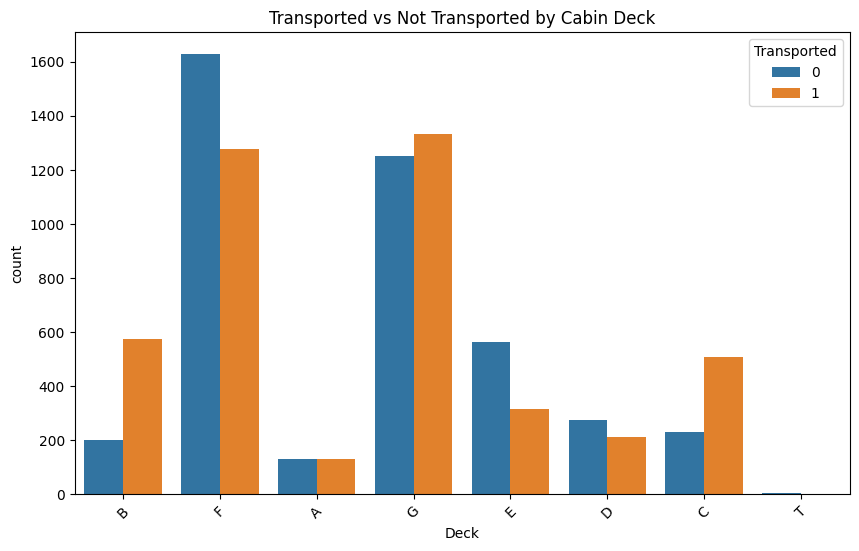

In [49]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Deck', hue='Transported', data=df)
plt.title('Transported vs Not Transported by Cabin Deck')
plt.xticks(rotation=45)

Text(0.5, 1.0, 'Correlation Matrix of Numerical Features')

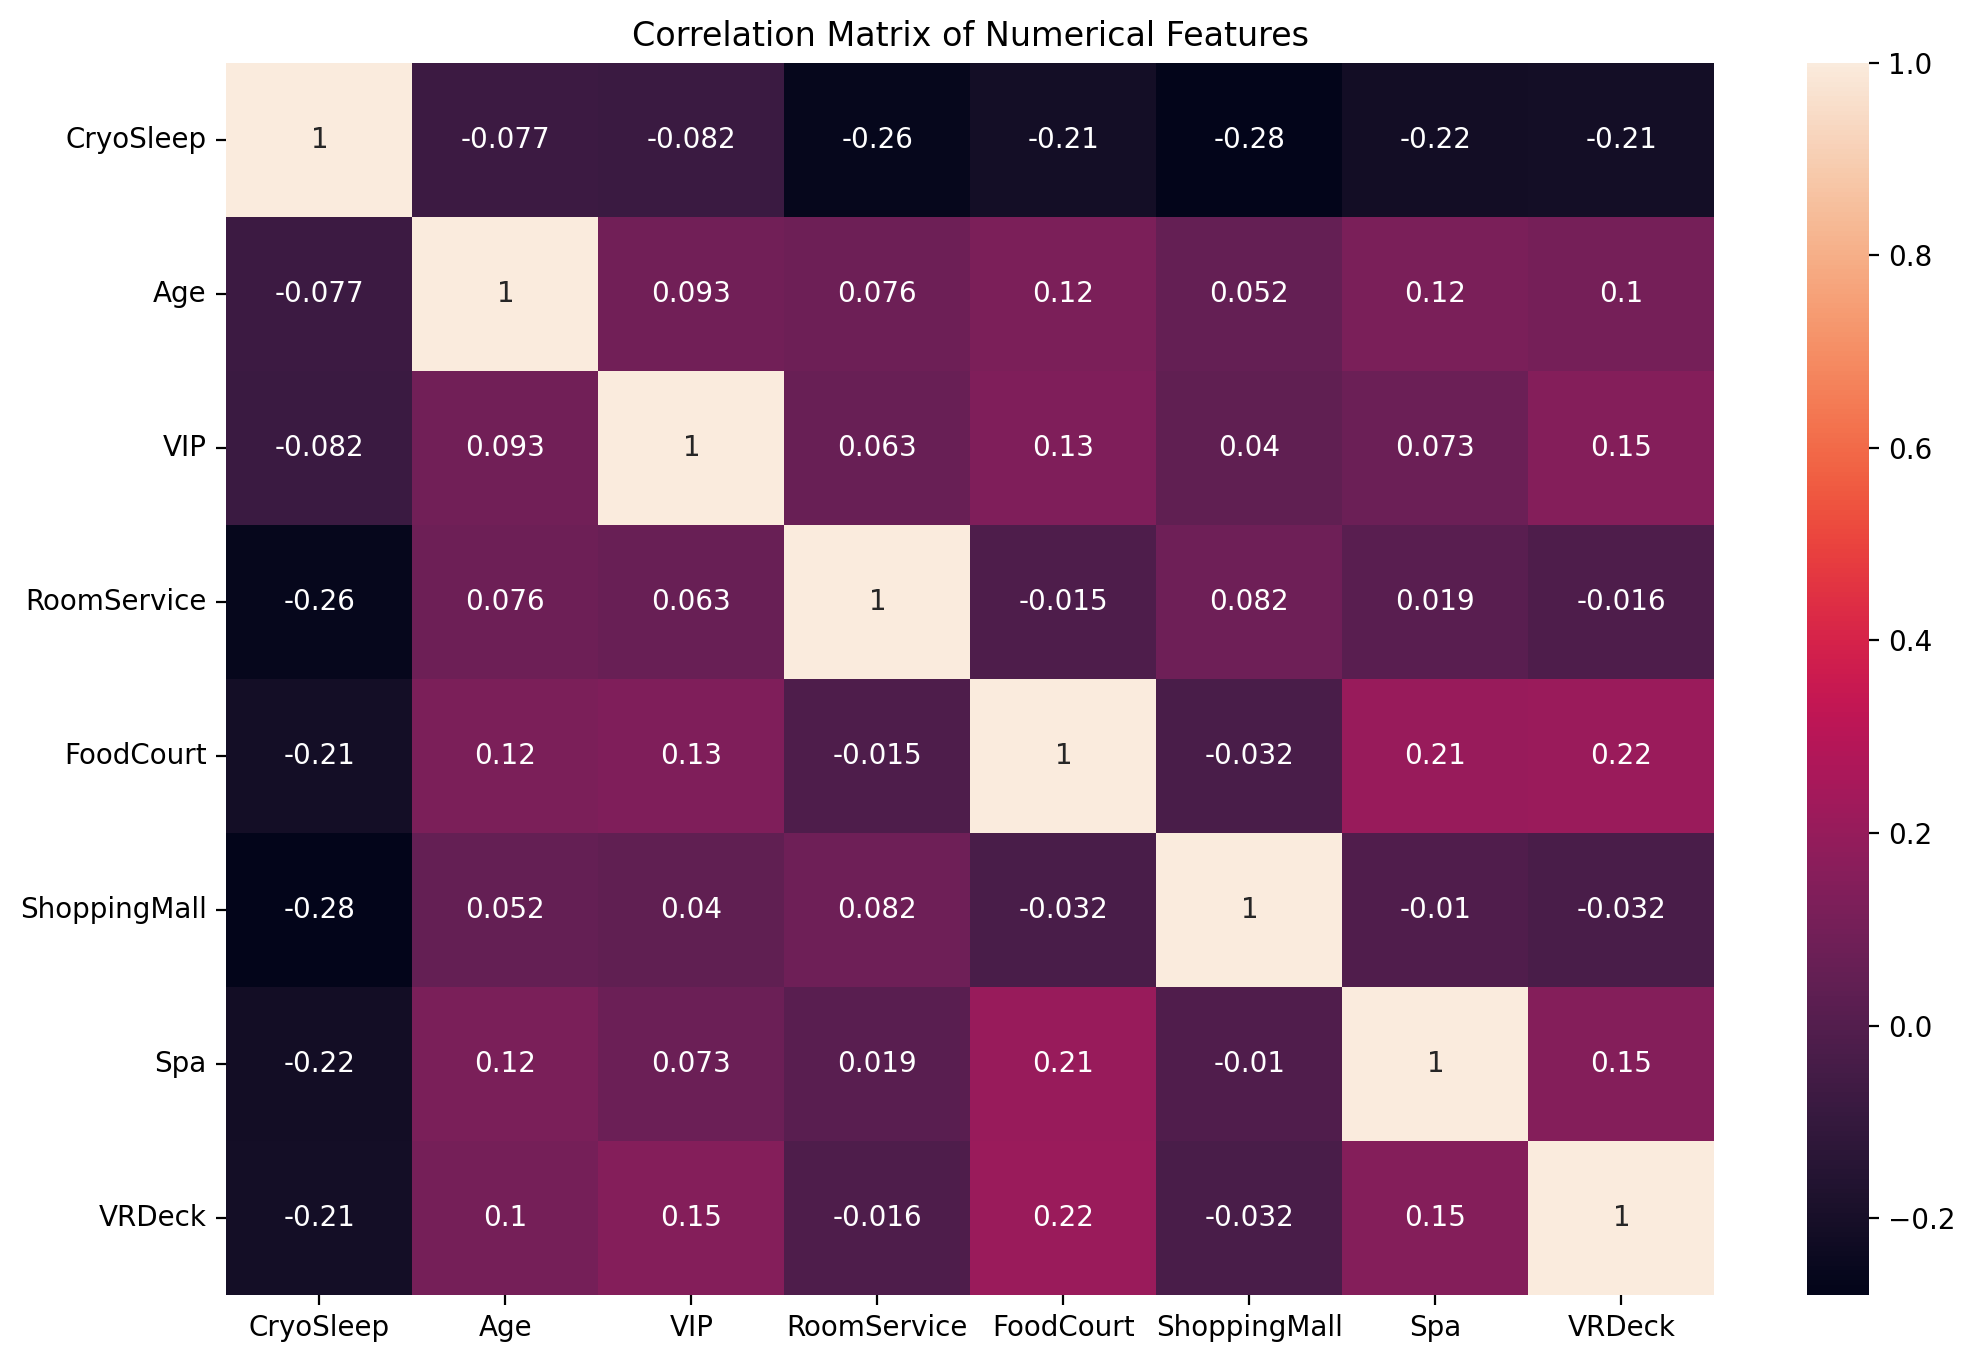

In [50]:
plt.figure(figsize=(12, 8), dpi=200)
correlation_matrix = df[df.select_dtypes(include=float).columns].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix of Numerical Features')

Видим, что явной линейной зависимости между признаками нет, это замечательно.

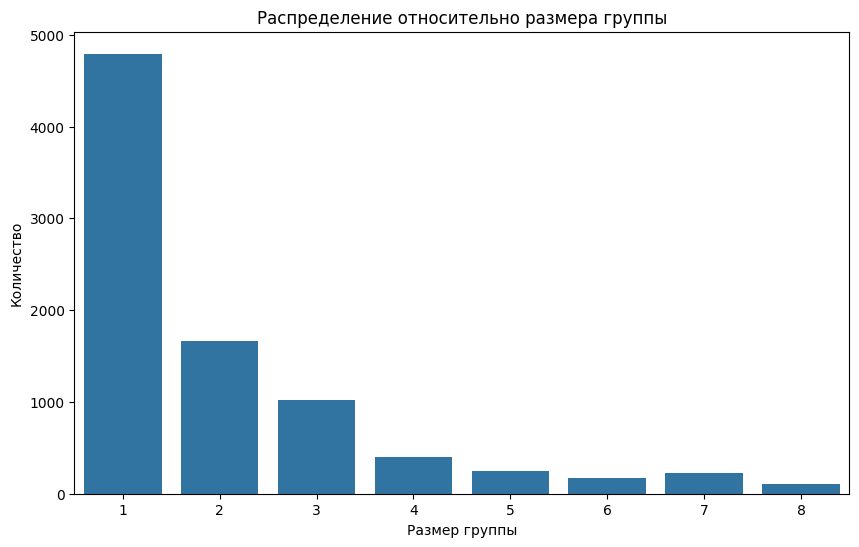

In [60]:
df['Group_Size'] = df.groupby('№_of_group')['№_in_group'].transform('count')

plt.figure(figsize=(10, 6))
sns.countplot(x='Group_Size', data=df, order=sorted(df['Group_Size'].unique()))
plt.title('Распределение относительно размера группы')
plt.xlabel('Размер группы')
plt.ylabel('Количество')
plt.show()

## Baseline

Теперь подготовим данные для обучения и сделаем baseline

Мы сделаем следующее:

1) Закодируем категориальные признаки с помощью TargetEncoder


В качестве baseline будем использовать random forest  с параметрами по умолчанию

Удалим №_of_group, №_in_group так как они очевидно сильно коррелированы с размером группы

In [61]:
df = df.drop(['PassengerId', 'Cabin', '№_of_group', '№_in_group', 'Name'], axis=1)

In [62]:
X, y = df.drop('Transported', axis=1), df['Transported']

In [63]:
categorical_features = [col for col in X.columns if df[col].dtype == 'object' ]

numerical_features = [
    col for col in X.columns if col not in categorical_features]

numerical_features

['CryoSleep',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Num',
 'Group_Size']

In [64]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

Поскольку работаем с решающем деревом, то масштабирование нам не нужно, поскольку на каждом разбиении и в каждом предикате оно работает только с одним из них 

In [65]:
enc = TargetEncoder(cols=categorical_features)

enc.fit(X_train, y_train)
X_train_new = enc.transform(X_train)
X_test_new = enc.transform(X_val)


In [24]:


model = RandomForestClassifier()
model.fit(X_train_new, y_train)
pred = model.predict(X_test_new)
predict_proba = model.predict_proba(X_test_new)[:, 1]

In [23]:
model

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
def print_metrics(predict, predict_proba, y_test):
    print({
        'accuracy' : accuracy_score(y_test, predict),
        'precision' : precision_score(y_test, predict),
        'recall' : recall_score(y_test, predict),
        'roc-auc' : roc_auc_score(y_test, predict_proba),
        'f1_score' : f1_score(y_test, predict)
    })

In [26]:
print_metrics(pred, predict_proba, y_val)

{'accuracy': 0.7967592592592593, 'precision': 0.8284313725490197, 'recall': 0.7619477006311993, 'roc-auc': 0.8845596833793913, 'f1_score': 0.7937999060591827}


Зафиксируем baseline метрики.


Далее будем пытаться повысить roc-auc, на него можно опираться, поскольку он не зависит от порога перевода вероятностей в классы(это может нам помочь например для приоритетной эвакуации)

Также будем повышать f1
Поскольку нам нужен баланс между
 - Не отправлять лишних пассажиров в переполненные капсулы (Precision)
 - Не оставлять нуждающихся на корабле (Recall)

Теперь подберем гиперпараметры

In [27]:

param_grid = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [5, 10, 20, 30],
    'min_samples_leaf': [5, 10, 15, 20],
    'max_features': ['sqrt', 'log2', None, 0.5, 0.7],
    'bootstrap': [True],  
    'oob_score': [True],  
    'random_state': [42] 
}

grid_model = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_model.fit(X_train_new, y_train)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'bootstrap': [True], 'max_depth': [10, 20, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [5, 10, ...], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


In [28]:

pred = grid_model.predict(X_test_new)
predict_proba = grid_model.predict_proba(X_test_new)[:, 1]


In [29]:
print_metrics(pred, predict_proba, y_val)

{'accuracy': 0.8125, 'precision': 0.8271375464684015, 'recall': 0.8025247971145176, 'roc-auc': 0.8955608424798744, 'f1_score': 0.8146453089244852}


In [30]:
grid_model.best_estimator_

,n_estimators,300
,criterion,'gini'
,max_depth,20
,min_samples_split,20
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,0.5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [33]:
grid_model.feature_names_in_

array(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Deck', 'Num', 'Side', 'Group_Size'], dtype=object)

ВЫВОДЫ ИЗ GRID SEARCH:

Сбалансированная сложность (не слишком простая, не слишком сложная)

Хорошая регуляризация через min_samples_leaf=5

Оптимальное разнообразие через max_features=0.5



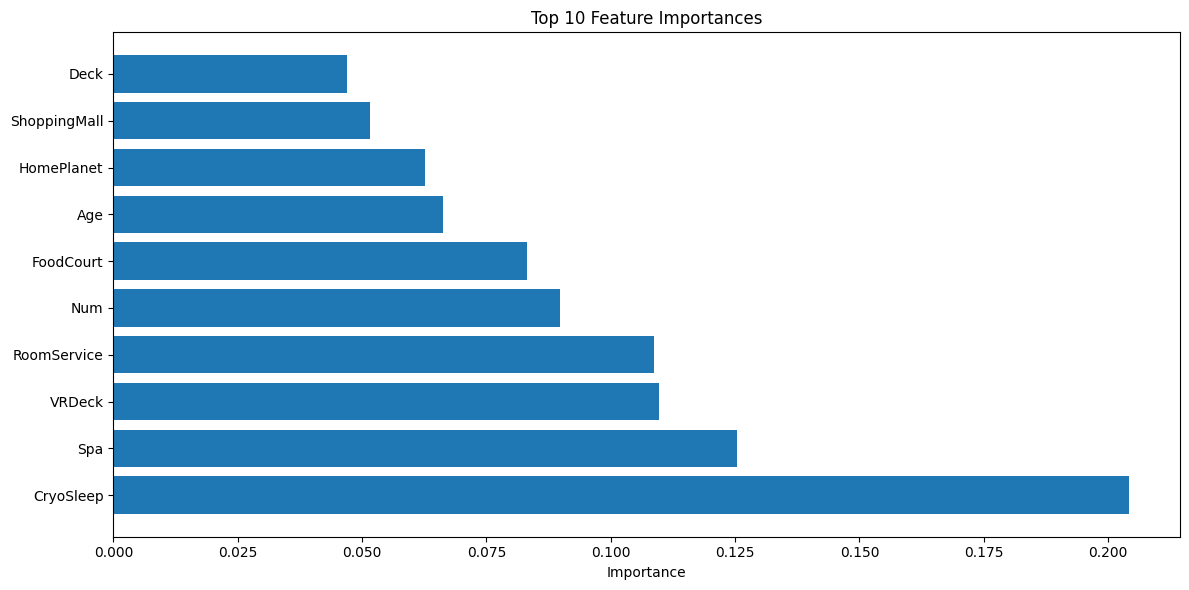

In [37]:
import numpy as np
import matplotlib.pyplot as plt

best_model = grid_model.best_estimator_
if hasattr(best_model, 'named_steps'):
    rf_model = best_model.named_steps['model']
else:
    rf_model = best_model

importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

if hasattr(X_train_new, 'columns'):
    feature_names = X_train_new.columns.tolist()
    top_features = [feature_names[i] for i in sorted_idx[:10]]
else:
    top_features = [f'Feature {i}' for i in sorted_idx[:10]]

plt.figure(figsize=(12, 6))
plt.barh(range(10), importances[sorted_idx[:10]][::-1])
plt.yticks(range(10), top_features[::-1])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Локация на корабле и демография сильнее влияют на выживание, чем платные услуги или криосон.

## Собственная Имплементация случайного леса(классификатор)

In [38]:
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import check_classification_targets

class MyRandomForestClassifier(BaseEstimator, ClassifierMixin):
    
    class DecisionTree:
        class Node:
            def __init__(self, feature_idx=None, threshold=None, left=None, right=None,
                        value=None, impurity=None, n_samples=None, depth=0):
                self.feature_idx = feature_idx
                self.threshold = threshold
                self.left = left
                self.right = right
                self.value = value
                self.impurity = impurity
                self.n_samples = n_samples
                self.depth = depth
            
            def is_leaf(self):
                return self.value is not None
        
        def __init__(self, criterion='gini', max_depth=None, min_samples_split=2,
                     min_samples_leaf=1, max_features=None, random_state=None,
                     n_features_total=None):
            self.criterion = criterion
            self.max_depth = max_depth
            self.min_samples_split = min_samples_split
            self.min_samples_leaf = min_samples_leaf
            self.max_features = max_features
            self.random_state = random_state
            self.n_features_total = n_features_total
            self.root = None
            self.feature_importances_ = None
            self.classes_ = None
            self.n_classes_ = None
            self.n_features_in_ = None
            
            if random_state is not None:
                np.random.seed(random_state)
        
        def _gini(self, y, class_counts, total):
            gini = 1.0
            for count in class_counts.values():
                prob = count / total
                gini -= prob ** 2
            return gini
        
        def _entropy(self, y, class_counts, total):
            entropy = 0.0
            for count in class_counts.values():
                prob = count / total
                if prob > 0:
                    entropy -= prob * np.log2(prob)
            return entropy
        
        def _compute_impurity(self, y):
            if len(y) == 0:
                return 0
            total = len(y)
            class_counts = Counter(y)
            if self.criterion == 'gini':
                return self._gini(y, class_counts, total)
            else:
                return self._entropy(y, class_counts, total)
        
        def _best_split(self, X, y, feature_indices):
            n_samples, _ = X.shape
            if n_samples < self.min_samples_split:
                return None, None, None
            
            current_impurity = self._compute_impurity(y)
            if current_impurity == 0:
                return None, None, None
            
            best_gain = -1
            best_feature = None
            best_threshold = None
            best_feature_global_idx = None
            
            for feature_local_idx, feature_global_idx in enumerate(feature_indices):
                feature_values = X[:, feature_local_idx]
                unique_values = np.unique(feature_values)
                
                for i in range(len(unique_values) - 1):
                    threshold = (unique_values[i] + unique_values[i + 1]) / 2
                    
                    left_mask = feature_values <= threshold
                    right_mask = ~left_mask
                    
                    if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
                        continue
                    
                    y_left = y[left_mask]
                    y_right = y[right_mask]
                    
                    impurity_left = self._compute_impurity(y_left)
                    impurity_right = self._compute_impurity(y_right)
                    
                    n_left = len(y_left)
                    n_right = len(y_right)
                    
                    weighted_impurity = (n_left * impurity_left + n_right * impurity_right) / n_samples
                    gain = current_impurity - weighted_impurity
                    
                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature_local_idx
                        best_feature_global_idx = feature_global_idx
                        best_threshold = threshold
            
            return best_feature, best_feature_global_idx, best_threshold
        
        def _grow_tree(self, X, y, feature_indices, depth=0):
            n_samples = X.shape[0]
            
            if len(np.unique(y)) == 1:
                value = Counter(y).most_common(1)[0][0]
                return self.Node(value=value, impurity=self._compute_impurity(y), 
                               n_samples=n_samples, depth=depth)
            
            if (self.max_depth is not None and depth >= self.max_depth) or (n_samples < self.min_samples_split):
                value = Counter(y).most_common(1)[0][0]
                return self.Node(value=value, impurity=self._compute_impurity(y), 
                               n_samples=n_samples, depth=depth)
            
            best_feature_local, best_feature_global, best_threshold = self._best_split(X, y, feature_indices)
            
            if best_feature_local is None:
                value = Counter(y).most_common(1)[0][0]
                return self.Node(value=value, impurity=self._compute_impurity(y), 
                               n_samples=n_samples, depth=depth)
            
            left_mask = X[:, best_feature_local] <= best_threshold
            right_mask = ~left_mask
            
            left_subtree = self._grow_tree(X[left_mask], y[left_mask], feature_indices, depth + 1)
            right_subtree = self._grow_tree(X[right_mask], y[right_mask], feature_indices, depth + 1)
            
            return self.Node(feature_idx=best_feature_global, threshold=best_threshold,
                           left=left_subtree, right=right_subtree,
                           impurity=self._compute_impurity(y), n_samples=n_samples, depth=depth)
        
        def _compute_feature_importance(self, node):
            if node.is_leaf():
                return
            
            gain = node.impurity - (
                (node.left.n_samples / node.n_samples) * node.left.impurity +
                (node.right.n_samples / node.n_samples) * node.right.impurity
            )
            
            self.feature_importances_[node.feature_idx] += gain * node.n_samples
            
            self._compute_feature_importance(node.left)
            self._compute_feature_importance(node.right)
        
        def fit(self, X, y):
            self.classes_ = np.unique(y)
            self.n_classes_ = len(self.classes_)
            n_samples, self.n_features_in_ = X.shape
            
            if self.max_features is None:
                max_features = self.n_features_in_
            elif isinstance(self.max_features, str):
                if self.max_features == 'sqrt':
                    max_features = int(np.sqrt(self.n_features_in_))
                elif self.max_features == 'log2':
                    max_features = int(np.log2(self.n_features_in_))
                else:
                    max_features = self.n_features_in_
            elif isinstance(self.max_features, int):
                max_features = min(self.max_features, self.n_features_in_)
            elif isinstance(self.max_features, float):
                max_features = max(1, int(self.max_features * self.n_features_in_))
            else:
                max_features = self.n_features_in_
            
            feature_indices = np.random.choice(self.n_features_in_, max_features, replace=False)
            X_selected = X[:, feature_indices]
            
            self.feature_importances_ = np.zeros(self.n_features_total)
            self.root = self._grow_tree(X_selected, y, feature_indices)
            self._compute_feature_importance(self.root)
            
            if self.feature_importances_.sum() > 0:
                self.feature_importances_ /= self.feature_importances_.sum()
            
            return self
        
        def _predict_single(self, x, node, feature_indices_mapping):
            if node.is_leaf():
                return node.value
            
            feature_global_idx = node.feature_idx
            if feature_global_idx not in feature_indices_mapping:
                return self._predict_single(x, node.left, feature_indices_mapping)
            
            feature_local_idx = feature_indices_mapping[feature_global_idx]
            
            if x[feature_local_idx] <= node.threshold:
                return self._predict_single(x, node.left, feature_indices_mapping)
            else:
                return self._predict_single(x, node.right, feature_indices_mapping)
        
        def predict(self, X):
            predictions = []
            feature_indices = list(range(X.shape[1]))
            feature_indices_mapping = {idx: idx for idx in feature_indices}
            
            for x in X:
                predictions.append(self._predict_single(x, self.root, feature_indices_mapping))
            return np.array(predictions)
        
        def predict_proba(self, X):
            predictions = self.predict(X)
            proba = np.zeros((len(X), self.n_classes_))
            for i, pred in enumerate(predictions):
                class_idx = np.where(self.classes_ == pred)[0][0]
                proba[i, class_idx] = 1.0
            return proba
        
        def get_depth(self):
            return self._get_node_depth(self.root)
        
        def _get_node_depth(self, node):
            if node.is_leaf():
                return node.depth
            return max(self._get_node_depth(node.left), self._get_node_depth(node.right))
        
        def get_n_leaves(self):
            return self._count_leaves(self.root)
        
        def _count_leaves(self, node):
            if node.is_leaf():
                return 1
            return self._count_leaves(node.left) + self._count_leaves(node.right)
    
    def __init__(self, n_estimators=100, criterion='gini', max_depth=None,
                 min_samples_split=2, min_samples_leaf=1, max_features='sqrt',
                 bootstrap=True, oob_score=False, random_state=None, n_jobs=None,
                 verbose=0, warm_start=False, class_weight=None):
        
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.oob_score = oob_score
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.warm_start = warm_start
        self.class_weight = class_weight
        
        self.estimators_ = []
        self.classes_ = None
        self.n_classes_ = None
        self.n_features_in_ = None
        self.feature_importances_ = None
        self.oob_score_ = None
        self.oob_decision_function_ = None
        
        if random_state is not None:
            np.random.seed(random_state)
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        check_classification_targets(y)
        
        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        self.n_features_in_ = X.shape[1]
        n_samples = X.shape[0]
        
        if not self.warm_start or len(self.estimators_) == 0:
            self.estimators_ = []
        
        if self.oob_score and not self.bootstrap:
            self.oob_score = False
        
        if self.oob_score:
            oob_votes = np.zeros((n_samples, self.n_classes_))
            oob_counts = np.zeros(n_samples)
        
        n_estimators_to_build = self.n_estimators
        if self.warm_start and len(self.estimators_) > 0:
            n_estimators_to_build = max(0, self.n_estimators - len(self.estimators_))
        
        for i in range(n_estimators_to_build):
            if self.verbose > 0 and i % 10 == 0:
                print(f"Building tree {i+1}/{n_estimators_to_build}")
            
            tree_random_state = None
            if self.random_state is not None:
                tree_random_state = self.random_state + i
            
            if self.bootstrap:
                indices = np.random.choice(n_samples, n_samples, replace=True)
                X_bootstrap = X[indices]
                y_bootstrap = y[indices]
                
                if self.oob_score:
                    oob_indices = np.setdiff1d(np.arange(n_samples), np.unique(indices))
            else:
                X_bootstrap = X
                y_bootstrap = y
            
            tree = self.DecisionTree(
                criterion=self.criterion,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features,
                random_state=tree_random_state,
                n_features_total=self.n_features_in_
            )
            
            tree.fit(X_bootstrap, y_bootstrap)
            self.estimators_.append(tree)
            
            if self.oob_score and self.bootstrap and len(oob_indices) > 0:
                oob_pred = tree.predict_proba(X[oob_indices])
                oob_votes[oob_indices] += oob_pred
                oob_counts[oob_indices] += 1
        
        if self.oob_score and self.bootstrap:
            valid_oob = oob_counts > 0
            if np.any(valid_oob):
                oob_votes[valid_oob] /= oob_counts[valid_oob, np.newaxis]
                self.oob_decision_function_ = oob_votes
                
                oob_pred_classes = np.argmax(oob_votes[valid_oob], axis=1)
                oob_true = y[valid_oob]
                
                from sklearn.metrics import accuracy_score
                self.oob_score_ = accuracy_score(oob_true, oob_pred_classes)
        
        self.feature_importances_ = np.zeros(self.n_features_in_)
        for tree in self.estimators_:
            self.feature_importances_ += tree.feature_importances_
        
        if len(self.estimators_) > 0:
            self.feature_importances_ /= len(self.estimators_)
        
        return self
    
    def _collect_votes(self, X):
        n_samples = X.shape[0]
        votes = np.zeros((n_samples, self.n_classes_))
        
        for tree in self.estimators_:
            tree_pred = tree.predict(X)
            for i, pred in enumerate(tree_pred):
                class_idx = np.where(self.classes_ == pred)[0][0]
                votes[i, class_idx] += 1
        
        return votes
    
    def predict(self, X):
        check_is_fitted(self, 'estimators_')
        X = check_array(X)
        
        votes = self._collect_votes(X)
        return self.classes_[np.argmax(votes, axis=1)]
    
    def predict_proba(self, X):
        check_is_fitted(self, 'estimators_')
        X = check_array(X)
        
        votes = self._collect_votes(X)
        return votes / votes.sum(axis=1, keepdims=True)
    
    def predict_log_proba(self, X):
        proba = self.predict_proba(X)
        return np.log(proba + 1e-15)
    
    def score(self, X, y):
        from sklearn.metrics import accuracy_score
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
    
    def get_params(self, deep=True):
        return {
            'n_estimators': self.n_estimators,
            'criterion': self.criterion,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'min_samples_leaf': self.min_samples_leaf,
            'max_features': self.max_features,
            'bootstrap': self.bootstrap,
            'oob_score': self.oob_score,
            'random_state': self.random_state,
            'n_jobs': self.n_jobs,
            'verbose': self.verbose,
            'warm_start': self.warm_start,
            'class_weight': self.class_weight
        }
    
    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self
    
    def get_depth(self):
        check_is_fitted(self, 'estimators_')
        depths = [tree.get_depth() for tree in self.estimators_]
        return np.mean(depths)
    
    def get_n_leaves(self):
        check_is_fitted(self, 'estimators_')
        n_leaves = [tree.get_n_leaves() for tree in self.estimators_]
        return np.mean(n_leaves)

В качестве baseline возьмем :
параметры  как в базовой реализации из sklearn 

In [66]:
my_rf = MyRandomForestClassifier()

my_rf.fit(X_train_new, y_train)

y_pred_my = my_rf.predict(X_test_new)
y_pred_proba_my = my_rf.predict_proba(X_test_new)




Чтобы пофиксить проблемы с рамерностями для roc-auc немного перепишем функцию для подсчета метрик 

In [67]:

def print_metrics(predict, predict_proba, y_test):

    if predict_proba.ndim == 2:
        y_proba = predict_proba[:, 1]
    else:
        y_proba = predict_proba
    
    print({
        'accuracy': accuracy_score(y_test, predict),
        'precision': precision_score(y_test, predict),
        'recall': recall_score(y_test, predict),
        'roc-auc': roc_auc_score(y_test, y_proba),  
        'f1_score': f1_score(y_test, predict)
    })

In [68]:
print_metrics(y_pred_my, y_pred_proba_my, y_val)

{'accuracy': 0.7546296296296297, 'precision': 0.7629427792915532, 'recall': 0.757439134355275, 'roc-auc': 0.8233182533016346, 'f1_score': 0.7601809954751131}


Видим что метрики немного ниже чем  в базовой реализацией из sklearn 

Теперь обучим с лучшими параметрами 

In [69]:


my_rf = MyRandomForestClassifier(
    n_estimators=300,
    criterion='gini',
    max_depth=20,
    min_samples_split=20,
    min_samples_leaf=5,
    max_features=0.5,
    bootstrap=True,
    oob_score=True,
    random_state=42,
    verbose=1
)
my_rf.fit(X_train_new, y_train)

y_pred_my = my_rf.predict(X_test_new)
y_pred_proba_my = my_rf.predict_proba(X_test_new)


Building tree 1/300
Building tree 11/300
Building tree 21/300
Building tree 31/300
Building tree 41/300
Building tree 51/300
Building tree 61/300
Building tree 71/300
Building tree 81/300
Building tree 91/300
Building tree 101/300
Building tree 111/300
Building tree 121/300
Building tree 131/300
Building tree 141/300
Building tree 151/300
Building tree 161/300
Building tree 171/300
Building tree 181/300
Building tree 191/300
Building tree 201/300
Building tree 211/300
Building tree 221/300
Building tree 231/300
Building tree 241/300
Building tree 251/300
Building tree 261/300
Building tree 271/300
Building tree 281/300
Building tree 291/300


In [71]:
print_metrics(y_pred_my, y_pred_proba_my, y_val)

{'accuracy': 0.8069444444444445, 'precision': 0.8270321361058601, 'recall': 0.7889990982867449, 'roc-auc': 0.883393719236864, 'f1_score': 0.8075680664513152}


Видим что удалось добиться почти таких же метрик как и на реализации из sklearn

# Случайный лес (регрессор)

Будем предсказывать цену машины по ее характеристикам 

In [90]:
data = pd.read_csv('train.csv')

In [87]:
data.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate,sellingprice
0,2013,Dodge,Dart,Limited,Sedan,automatic,1c3cdfca5dd293552,mo,4.6,13957.0,gray,black,chrysler capital,Wed Jan 21 2015 02:30:00 GMT-0800 (PST),14500
1,2014,Honda,Civic,LX,Sedan,automatic,19xfb2f56ee228781,ca,5.0,2401.0,gray,black,"ahfc/honda lease trust/hvt, inc.",Thu Feb 26 2015 04:00:00 GMT-0800 (PST),16500
2,2012,Chevrolet,Traverse,LT,suv,automatic,1gnkrged3cj244704,wi,2.4,70046.0,white,black,capital one auto finance,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT),13700
3,2014,Nissan,Versa Note,1.6 SV,Hatchback,automatic,3n1ce2cp9el407766,fl,2.6,23415.0,gray,black,florida auto financial group,Tue Feb 17 2015 01:30:00 GMT-0800 (PST),9800
4,2014,Nissan,Versa,1.6 SV,sedan,automatic,3n1cn7ap4el813308,il,3.4,17040.0,blue,black,nissan motor acceptance corporation,Thu Jun 04 2015 03:00:00 GMT-0700 (PDT),10300


In [88]:
data.describe()

,year,condition,odometer,sellingprice
count,396212.000000,387759.000000,396151.000000,396212.000000
mean,2010.041442,3.425687,68336.479029,13593.389859
std,3.977384,0.949871,53559.280598,9754.143816
min,1982.000000,1.000000,1.000000,1.000000
25%,2007.000000,2.700000,28259.000000,6900.000000
50%,2012.000000,3.600000,52113.000000,12100.000000
75%,2013.000000,4.200000,99300.000000,18200.000000
max,2015.000000,5.000000,999999.000000,230000.000000


In [91]:
X = data.drop('sellingprice', axis=1)
y = data['sellingprice']

## EDA

Посмтрим на категориальные признаки

In [90]:
X.describe(include='object')


,make,model,trim,body,transmission,vin,state,color,interior,seller,saledate
count,388993,388922,388727,386883,350025,396212,396212,395679,395679,396212,396212
unique,91,949,1899,83,2,396212,38,20,17,12530,3544
top,Ford,Altima,Base,Sedan,automatic,1c3cdfca5dd293552,fl,black,black,nissan-infiniti lt,Tue Feb 10 2015 01:30:00 GMT-0800 (PST)
freq,66391,13969,39538,141921,337646,1,59164,78576,173230,14323,3783


Признак vin это уникальный идентификатор машины, поэтому удалим его.


In [92]:

X.drop('vin', axis=1, inplace=True)

Заполним пропуски в числовых столбцах средним значением, а в категориальных - пустой категорией



In [93]:
for c in X.columns:
    if X[c].dtype == 'object':
          X[c].fillna("", inplace=True)
for c in X.columns:
    if X[c].dtype != 'object':
          mean = np.mean(X[c])
          X[c].fillna(mean, inplace=True)

/var/folders/sy/bq09pg_j1599sryhztwt0p880000gn/T/ipykernel_10643/122545764.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[c].fillna("", inplace=True)
/var/folders/sy/bq09pg_j1599sryhztwt0p880000gn/T/ipykernel_10643/122545764.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Посмотрим на количество значений в каждой категории



In [94]:
for c in X.columns:
    if X[c].dtype == 'object':
          print(c, len(X[c].unique()))

make 92
model 950
trim 1900
body 84
transmission 3
state 38
color 21
interior 18
seller 12530
saledate 3544


В saledate очень много различных значений. Посмотрим почему.



In [88]:
X[['year','saledate']]


,year,saledate
0,2013,Wed Jan 21 2015 02:30:00 GMT-0800 (PST)
1,2014,Thu Feb 26 2015 04:00:00 GMT-0800 (PST)
2,2012,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
3,2014,Tue Feb 17 2015 01:30:00 GMT-0800 (PST)
4,2014,Thu Jun 04 2015 03:00:00 GMT-0700 (PDT)
...,...,...
396207,2013,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
396208,2009,Mon Jun 08 2015 02:00:00 GMT-0700 (PDT)
396209,2004,Tue Jan 20 2015 02:30:00 GMT-0800 (PST)
396210,2013,Fri Dec 19 2014 11:45:00 GMT-0800 (PST)


Обработаем saledate:

сделаем признак car_age - возраст машины в годах
сделаем признак date - месяц+год продажи машины (категориальный)
Исходный признак saledate удалим

In [95]:
X['car_age'] = X['saledate'].apply(lambda x: int(x.split(" ")[3])) - X['year']
X['date'] = X['saledate'].apply(lambda x: x.split(" ")[1]+x.split(" ")[3])

X.drop('saledate', axis=1, inplace=True)


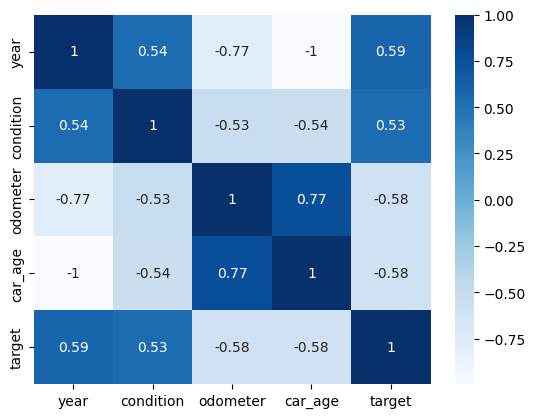

In [96]:
import seaborn as sb

X['target'] = y

cols = X.columns[X.dtypes != 'object']

corr = X[cols].corr()
sb.heatmap(corr, cmap="Blues", annot=True)

X.drop('target', axis=1, inplace=True)

Посмотрим на аналог корреляции категориальных признаков

In [97]:
!pip install association-metrics


  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'association-metrics' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'association-metrics'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for association-metrics: filename=association_metrics-0.0.1-py3-none-any.whl size=3978 sha256=6c0c0ab393dbb3b40dd3591d75a9815e4d2918df927abef9525afb35fc7ed805
  Stored in directory: /Users/fltww/Library/Caches/pip/wheels/01/47/5f/4360ef6988df6f1b0c1857cab43334269110160bd97b716936
Successfully built association-metrics


In [97]:
import association_metrics as am

XC = X.apply(
        lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(XC)

cramersv.fit()

/opt/anaconda3/envs/ml/lib/python3.10/site-packages/association_metrics/categorical.py:100: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.matrix[x][y] = 1
/opt/anaconda3/envs/ml/lib/python3.10/site-packages/association_metrics/categoric

,make,model,trim,body,transmission,state,color,interior,seller,date
make,1.000000,0.942073,0.768825,0.189035,0.161258,0.080016,0.085875,0.108237,0.405386,0.059136
model,0.942073,1.000000,0.552843,0.615147,0.310298,0.120689,0.145266,0.181734,0.287182,0.086036
trim,0.768825,0.552843,1.000000,0.437450,0.291284,0.131441,0.139243,0.210486,0.267798,0.099165
body,0.189035,0.615147,0.437450,1.000000,0.171188,0.054380,0.070882,0.073898,0.251710,0.298083
transmission,0.161258,0.310298,0.291284,0.171188,1.000000,0.377115,0.063472,0.066053,0.394181,0.031898
state,0.080016,0.120689,0.131441,0.054380,0.377115,1.000000,0.064536,0.062192,0.679166,0.081021
color,0.085875,0.145266,0.139243,0.070882,0.063472,0.064536,1.000000,0.259053,0.233966,0.018536
interior,0.108237,0.181734,0.210486,0.073898,0.066053,0.062192,0.259053,1.000000,0.258849,0.061795
seller,0.405386,0.287182,0.267798,0.251710,0.394181,0.679166,0.233966,0.258849,1.000000,0.286704
date,0.059136,0.086036,0.099165,0.298083,0.031898,0.081021,0.018536,0.061795,0.286704,1.000000


In [98]:
X.drop('make', axis=1, inplace=True)


Признаки make и model сильно связаны, поэтому уберем make как менее информативный



Посмотрим влияние на целевуб переменную 



<Axes: xlabel='None', ylabel='sellingprice'>

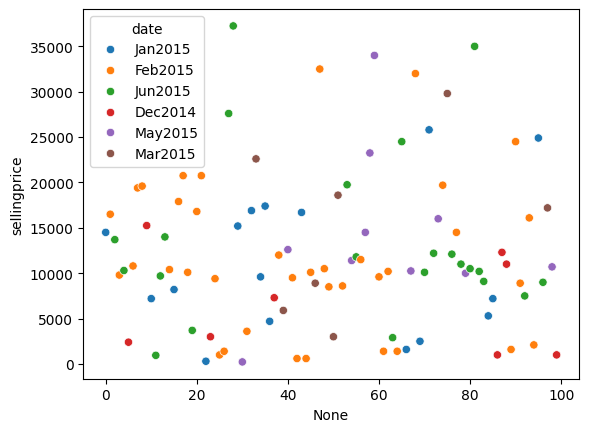

In [100]:
import seaborn as sns

sns.scatterplot(data=X.iloc[:100], x=X.iloc[:100].index, y=y[:100], hue='date')

<Axes: xlabel='None', ylabel='sellingprice'>

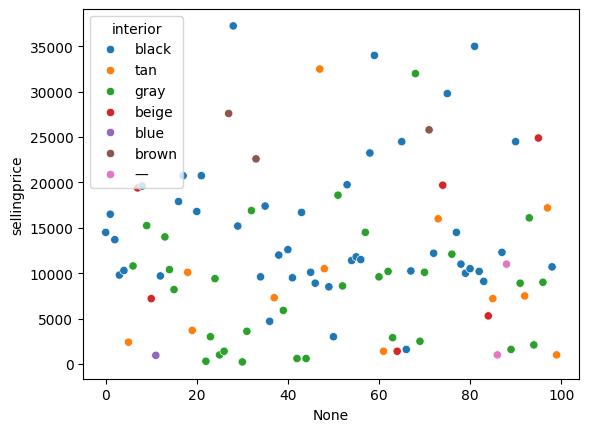

In [101]:
sns.scatterplot(data=X.iloc[:100], x=X.iloc[:100].index, y=y[:100], hue='interior')


<Axes: xlabel='None', ylabel='sellingprice'>

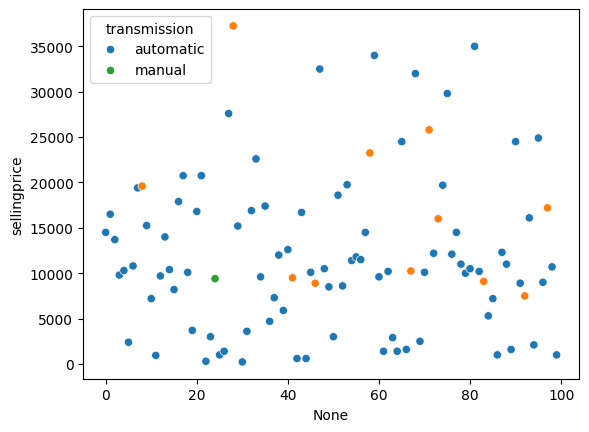

In [102]:
sns.scatterplot(data=X.iloc[:100], x=X.iloc[:100].index, y=y[:100], hue='transmission')


Посмотрим на распределение целевой переменной



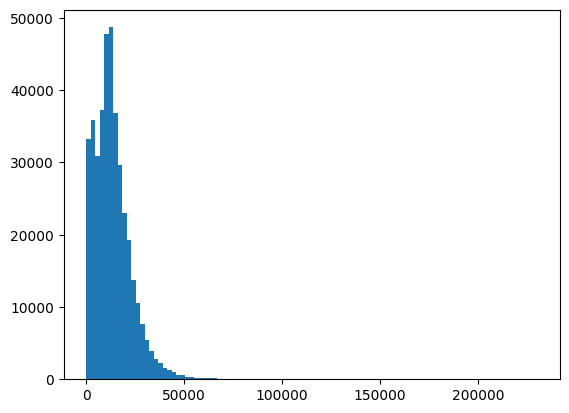

In [103]:
plt.hist(y, bins=100);


Видим что распределение не является нормальным, но пока ничего с ним делать не будем 

Поищем выбросы

In [99]:
cat_cols = X.columns[X.dtypes == 'object']
num_cols = X.columns[X.dtypes != 'object']

year


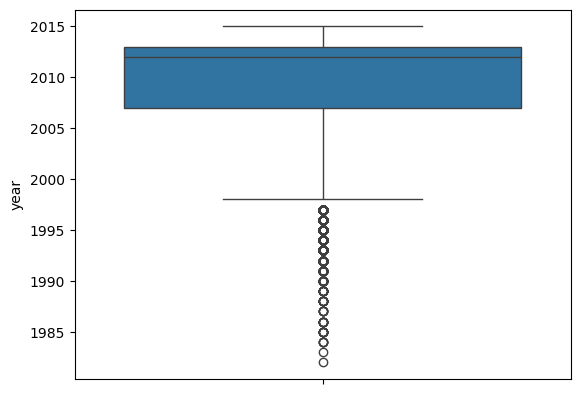

condition


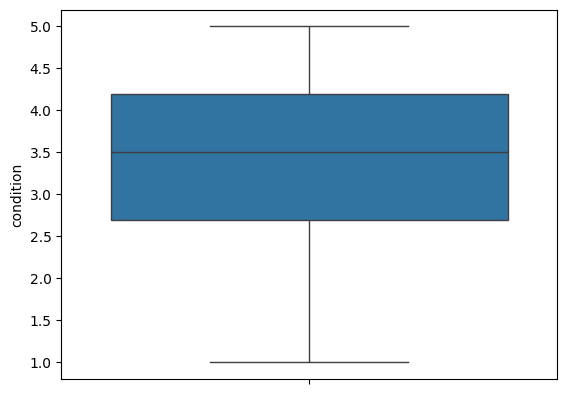

odometer


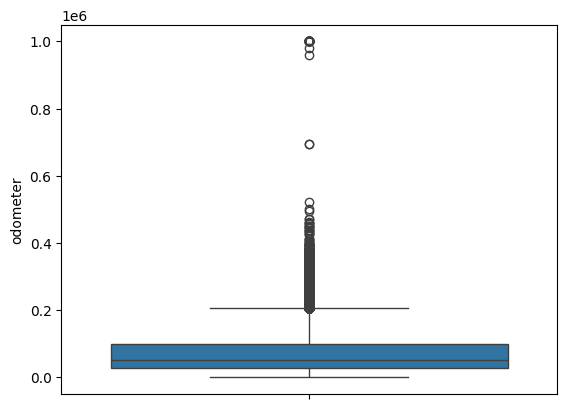

car_age


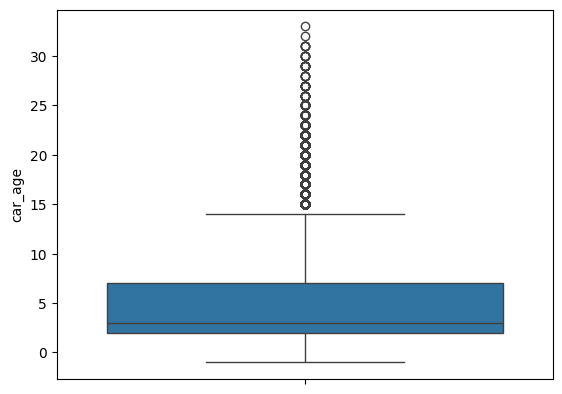

In [105]:
for col in num_cols:
    print(col)
    sb.boxplot(X[col])
    plt.show()

In [106]:
X[X['odometer'] > 800000][['car_age','odometer']]


,car_age,odometer
8651,8,999999.0
26775,8,999999.0
39643,8,999999.0
59125,8,999999.0
69969,9,999999.0
70028,10,999999.0
78649,9,999999.0
90539,14,999999.0
94884,2,999999.0
105833,8,999999.0


Выкинем машины младше 10 лет, проехавшие 1_000_000 миль - это почти точно выбросы.



In [100]:
Xnew = X[~((X.car_age < 10) & (X.odometer > 800_000))]
ynew = y[~((X.car_age < 10) & (X.odometer > 800_000))]

Xnew.drop('car_age', axis=1, inplace=True)

/var/folders/sy/bq09pg_j1599sryhztwt0p880000gn/T/ipykernel_10643/4066289098.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xnew.drop('car_age', axis=1, inplace=True)


### BASELINE

Для baseline-модели мы сделаем следующее:

закодируем категориальные признаки при помощи TargetEncoder

обучим случайный лес

In [81]:
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

In [101]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xnew, ynew, test_size=0.25, random_state=42)

In [102]:

enc = TargetEncoder(cols=cat_cols)

enc.fit(X_train, y_train)
X_train_new = enc.transform(X_train)
X_test_new = enc.transform(X_test)

model = RandomForestRegressor()
model.fit(X_train_new, y_train)
pred = model.predict(X_test_new)

В качестве метрик будем использовать комбинацию r2 + mae + mape 

Поскольку : 

R² - обьясняет насколько мы лучше чем банальное среднее 

MAE - смотрим общую картину

MAPE - оценим стабильность на дорогих и дешевых авто 

In [103]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

In [105]:
def print_metrics(y_true, y_pred , return_dict=False):
  
    def safe_mape(true, pred):
        true = np.where(true == 0, 1e-10, true)
        return np.mean(np.abs((true - pred) / true)) * 100
    
    def safe_mdape(true, pred):
        true = np.where(true == 0, 1e-10, true)
        return np.median(np.abs((true - pred) / true)) * 100
    
    metrics = {
        'R²': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': safe_mape(y_true, y_pred),
        'MdAPE': safe_mdape(y_true, y_pred),  
        'Max Error': np.max(np.abs(y_true - y_pred))
    }
    
    residuals = y_true - y_pred
    metrics.update({
        'Mean Residual': np.mean(residuals),
        'Std Residual': np.std(residuals)
    })
    
 
    
    for metric, value in metrics.items():
        if metric in ['R²']:
            print(f"{metric:>12}: {value:>8.4f}")
        elif metric in ['MAPE', 'MdAPE']:
            print(f"{metric:>12}: {value:>7.2f}%")
        elif metric in ['MAE', 'RMSE', 'Max Error', 'Mean Residual', 'Std Residual']:
            print(f"{metric:>12}: {value:>8.2f}")
        elif metric == 'MSE':
            print(f"{metric:>12}: {value:>8.2e}")
    
    if return_dict:
        return metrics

In [106]:
print_metrics(y_test, pred)

          R²:   0.9460
         MAE:  1292.73
        MAPE:   21.41%
       MdAPE:    7.28%
   Max Error: 73760.00
Mean Residual:    -8.51
Std Residual:  2266.01


 Сильные стороны: Высокий R², отличная медианная точность 

 Проблемы: Большая максимальная ошибка, относительно высокий средний процент ошибки но гораздо меньше относительно предыдущих моделей (21%)


при этом базовый лес  уже объясняет почти 95% вариативности цен, что является отличным результатом 

Теперь попробуем подобрать кодировщик а затем проведем подбор гиперпараметров 

In [107]:
from sklearn.pipeline import Pipeline

p0 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)),
    ('model_', RandomForestRegressor())
    ])

p1 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=100)),
    ('model_', RandomForestRegressor())
    ])

p2 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)),
    ('model_', RandomForestRegressor())
    ])

p3 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=10)),
    ('model_', RandomForestRegressor())
    ])

p4 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=100)),
    ('model_', RandomForestRegressor())
    ])

p5 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
    ('model_', RandomForestRegressor())
    ])

p6 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
    ('model_', RandomForestRegressor())
    ])

Выберем по лучшему mape 

In [108]:
for i,p in enumerate([p0, p1, p2, p3, p4, p5, p6]):
    p.fit(X_train, y_train)
    pred = p.predict(X_test)
    print(i, mean_absolute_percentage_error(y_test, pred))

0 0.21143784329422666
1 0.21224725396700198
2 0.21202009606582659
3 0.21244415769159047
4 0.2113845792300367
5 1.9471963349259958
6 1.9508603162089801


Видим что  TargetEncoder c smoothing=100  сработал лучше всего 

In [109]:
print_metrics(y_test, p4.predict(X_test))

          R²:   0.9504
         MAE:  1278.00
        MAPE:   21.14%
       MdAPE:    7.29%
   Max Error: 65198.50
Mean Residual:    -8.63
Std Residual:  2172.61


Теперь стало лучше r2 обьясняет уже около 95%  дисперсии цен на обычном случайном лесе без подбора параметров, и все остальные метрики улучшились 

Поскольку результаты отличные подбирать гиперпараметры не будем

Важность признаков

In [112]:
rf_model = p4.named_steps['model_'] 
importances = rf_model.feature_importances_

feature_names = p4.named_steps['encoder_'].get_feature_names_out() 

import pandas as pd
feat_imp_df = pd.DataFrame({
    'feature': feature_names,  
    'importance': importances
}).sort_values('importance', ascending=False)

print(feat_imp_df.head(10))

      feature  importance
1       model    0.414172
7    odometer    0.338811
0        year    0.086501
2        trim    0.070052
10     seller    0.035323
3        body    0.020266
6   condition    0.017034
5       state    0.004933
11       date    0.004264
8       color    0.003779


Видим что на цену машины больше всего влияет модель и пробег, что также логично 

### Имплементация  случайного леса(регрессор)

In [114]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils import resample

class MyRandomForestRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, 
                 n_estimators=100,
                 criterion='squared_error',
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.0,
                 max_features='sqrt',
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.0,
                 bootstrap=True,
                 oob_score=False,
                 random_state=None,
                 verbose=0,
                 warm_start=False,
                 ccp_alpha=0.0,
                 monotonic_cst=None):
        
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.bootstrap = bootstrap
        self.oob_score = oob_score
        self.random_state = random_state
        self.verbose = verbose
        self.warm_start = warm_start
        self.ccp_alpha = ccp_alpha
        self.monotonic_cst = monotonic_cst
        
        self.estimators_ = []
        self.feature_importances_ = None
        self.n_features_in_ = None
        self.oob_prediction_ = None
        self.oob_score_ = None
        self.oob_samples_ = []

    def fit(self, X, y):
        X, y = check_X_y(X, y, y_numeric=True)
        self.n_features_in_ = X.shape[1]
        
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        if not self.warm_start or len(self.estimators_) == 0:
            self.estimators_ = []
            self.oob_samples_ = []
        
        n_samples = X.shape[0]
        n_estimators_to_fit = self.n_estimators - len(self.estimators_)
        
        for i in range(n_estimators_to_fit):
            tree = MyDecisionTreeRegressor(
                criterion=self.criterion,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                min_impurity_decrease=self.min_impurity_decrease,
                max_features=self.max_features,
                random_state=None if self.random_state is None else self.random_state + i,
                min_weight_fraction_leaf=self.min_weight_fraction_leaf,
                ccp_alpha=self.ccp_alpha,
                monotonic_cst=self.monotonic_cst
            )
            
            if self.bootstrap:
                indices = resample(np.arange(n_samples), 
                                  n_samples=n_samples,
                                  random_state=None if self.random_state is None else self.random_state + i)
                X_bootstrap = X[indices]
                y_bootstrap = y[indices]
                
                oob_mask = np.ones(n_samples, dtype=bool)
                oob_mask[indices] = False
                self.oob_samples_.append(oob_mask)
                
                tree.fit(X_bootstrap, y_bootstrap)
            else:
                self.oob_samples_.append(np.zeros(n_samples, dtype=bool))
                tree.fit(X, y)
            
            self.estimators_.append(tree)
            
            if self.verbose > 0 and (i + 1) % 10 == 0:
                print(f"Fitted tree {i + 1}/{self.n_estimators}")
        
        self._compute_feature_importances()
        
        if self.oob_score:
            self._compute_oob_predictions(X, y)
        
        return self

    def _compute_feature_importances(self):
        importances = np.zeros(self.n_features_in_)
        
        for tree in self.estimators_:
            if hasattr(tree, 'feature_importances_'):
                importances += tree.feature_importances_
        
        if len(self.estimators_) > 0:
            importances /= len(self.estimators_)
        
        self.feature_importances_ = importances

    def _compute_oob_predictions(self, X, y):
        n_samples = X.shape[0]
        oob_predictions = np.zeros(n_samples)
        oob_counts = np.zeros(n_samples)
        
        for i, tree in enumerate(self.estimators_):
            oob_mask = self.oob_samples_[i]
            
            if np.any(oob_mask):
                X_oob = X[oob_mask]
                pred_oob = tree.predict(X_oob)
                oob_predictions[oob_mask] += pred_oob
                oob_counts[oob_mask] += 1
        
        valid_oob = oob_counts > 0
        if np.any(valid_oob):
            self.oob_prediction_ = np.full(n_samples, np.nan)
            self.oob_prediction_[valid_oob] = oob_predictions[valid_oob] / oob_counts[valid_oob]
            
            y_oob = y[valid_oob]
            pred_oob = self.oob_prediction_[valid_oob]
            self.oob_score_ = 1 - np.sum((y_oob - pred_oob) ** 2) / np.sum((y_oob - np.mean(y_oob)) ** 2)
        else:
            self.oob_prediction_ = None
            self.oob_score_ = None

    def predict(self, X):
        check_is_fitted(self, 'estimators_')
        X = check_array(X)
        
        predictions = np.zeros((X.shape[0], len(self.estimators_)))
        
        for i, tree in enumerate(self.estimators_):
            predictions[:, i] = tree.predict(X)
        
        return np.mean(predictions, axis=1)

    def get_params(self, deep=True):
        params = {
            'n_estimators': self.n_estimators,
            'criterion': self.criterion,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'min_samples_leaf': self.min_samples_leaf,
            'min_weight_fraction_leaf': self.min_weight_fraction_leaf,
            'max_features': self.max_features,
            'max_leaf_nodes': self.max_leaf_nodes,
            'min_impurity_decrease': self.min_impurity_decrease,
            'bootstrap': self.bootstrap,
            'oob_score': self.oob_score,
            'random_state': self.random_state,
            'verbose': self.verbose,
            'warm_start': self.warm_start,
            'ccp_alpha': self.ccp_alpha,
            'monotonic_cst': self.monotonic_cst
        }
        
        if deep:
            for tree in self.estimators_:
                if hasattr(tree, 'get_params'):
                    tree_params = tree.get_params(deep=True)
                    for key, value in tree_params.items():
                        params[f'tree__{key}'] = value
        
        return params

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


    def apply(self, X):
        check_is_fitted(self, 'estimators_')
        X = check_array(X)
        
        leaf_indices = np.zeros((X.shape[0], len(self.estimators_)), dtype=int)
        
        for i, tree in enumerate(self.estimators_):
            if hasattr(tree, 'apply'):
                leaf_indices[:, i] = tree.apply(X)
        
        return leaf_indices

    def decision_path(self, X):
        check_is_fitted(self, 'estimators_')
        X = check_array(X)
        
        from scipy.sparse import hstack
        
        paths = []
        for tree in self.estimators_:
            if hasattr(tree, 'decision_path'):
                paths.append(tree.decision_path(X))
        
        if paths:
            return hstack(paths, format='csr')
        return None

In [121]:
cat_cols = list(X_train.select_dtypes(include=object).columns) 
float_cols = list(X_train.select_dtypes(include=float).columns)
int_cols = list(X_train.select_dtypes(include=int).columns)
num_cols = float_cols + int_cols

In [120]:
X_train.columns

Index(['year', 'model', 'trim', 'body', 'transmission', 'state', 'condition',
       'odometer', 'color', 'interior', 'seller', 'date'],
      dtype='object')

In [ ]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', TargetEncoder(cols=cat_cols, smoothing=100), cat_cols),
    ]
)

my_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())
])

my_pipeline.fit(X_train, y_train)




In [123]:
y_pred_my = my_pipeline.predict(X_test)


In [124]:
print_metrics(y_test, y_pred_my)

          R²:   0.8154
         MAE:  2604.74
        MAPE:   47.07%
       MdAPE:   14.40%
   Max Error: 89496.00
Mean Residual:   -60.78
Std Residual:  4190.01


Результаты  хуже чем на реализации из skylearn, возможно дело во внутреннем устройстве 